In [19]:
import pandas as pd
path = r"C:\Users\user\Desktop\токс\clean\full_combined_cleaned.csv"
# загрузка
df = pd.read_csv(path)
print("Размер данных:", df.shape)
print("\nУникальные значения assay_value:")
print(df['assay_value'].value_counts(dropna=False))
print("\nОбщее количество уникальных молекул:", df['smiles'].nunique())
print("Общее количество уникальных тестов (assay_name):", df['assay_name'].nunique())

Размер данных: (516799, 5)

Уникальные значения assay_value:
assay_value
0.0    433055
1.0     83744
Name: count, dtype: int64

Общее количество уникальных молекул: 339061
Общее количество уникальных тестов (assay_name): 129


In [20]:
# распределения
print("\nРаспределение по источникам данных:")
print(df['source'].value_counts())

print("\nРаспределение по категориям токсичности:")
print(df['toxicity_category'].value_counts())


Распределение по источникам данных:
source
tdc             329384
tox21            76540
toxcast          56918
toxric           26047
sider            21405
ToxBenchmark      6505
Name: count, dtype: int64

Распределение по категориям токсичности:
toxicity_category
cardiotoxicity               324653
immunotoxicity                48261
endocrine_disruption          40370
genotoxicity                  34785
dermal_toxicity               12956
oxidative_stress              12064
ocular_toxicity               10986
acute_toxicity                 9679
neurotoxicity                  5324
hepatotoxicity                 4056
other_toxicity                 2588
respiratory_toxicity           2372
carcinogenicity                1914
gastrointestinal_toxicity      1263
reproductive_toxicity           986
metabolic_toxicity              973
musculoskeletal_toxicity        972
nephrotoxicity                  894
hematotoxicity                  872
sensory_toxicity                643
developmenta

In [21]:
# Найдем и удалим противоречивые записи (по одной молекуле и одному тесту)
conflicting_pairs = (
    df.groupby(['smiles', 'assay_name'])['assay_value']
    .nunique()
    .reset_index())
conflicting_pairs = conflicting_pairs[conflicting_pairs['assay_value'] > 1]
print(f"Найдено противоречивых комбинаций (smiles + assay_name): {len(conflicting_pairs)}")
# удаляем их из нового датафрейма
df_clean = df.merge(
    conflicting_pairs[['smiles', 'assay_name']],
    on=['smiles', 'assay_name'],
    how='left',
    indicator=True)
df_clean = df_clean[df_clean['_merge'] == 'left_only'].drop(columns='_merge')
print("После удаления противоречивых записей:", df_clean.shape)
# Удаляем полные дубликаты по (smiles, assay_name, assay_value)
before = df_clean.shape[0]
df_clean = df_clean.drop_duplicates(subset=['smiles', 'assay_name', 'assay_value'])
after = df_clean.shape[0]
print(f"Удалено {before - after} полных дубликатов")
print("Размер после очистки:", df_clean.shape)

Найдено противоречивых комбинаций (smiles + assay_name): 14
После удаления противоречивых записей: (516771, 5)
Удалено 387 полных дубликатов
Размер после очистки: (516384, 5)


In [22]:
# Агрегируем assay_value внутри каждой категории по каждой молекуле
agg_df = (
    df_clean.groupby(['smiles', 'toxicity_category'])['assay_value']
    .max()  # ставим 1, если хоть один тест в категории = 1
    .reset_index())
# Преобразуем в формат multi-target (одна строка на молекулу, колонки = категории)
multi_target_df = agg_df.pivot(
    index='smiles',
    columns='toxicity_category',
    values='assay_value').reset_index()
# Проверка результата
print("Форма multi-target таблицы:", multi_target_df.shape)
display(multi_target_df.head())


Форма multi-target таблицы: (339055, 22)


toxicity_category,smiles,acute_toxicity,carcinogenicity,cardiotoxicity,dermal_toxicity,developmental_toxicity,endocrine_disruption,gastrointestinal_toxicity,genotoxicity,hematotoxicity,...,metabolic_toxicity,musculoskeletal_toxicity,nephrotoxicity,neurotoxicity,ocular_toxicity,other_toxicity,oxidative_stress,reproductive_toxicity,respiratory_toxicity,sensory_toxicity
0,Br.CC(Cc1ccc(O)cc1)NCC(O)c1cc(O)cc(O)c1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Br.COc1ccc2c(c1)[C@]13CCCC[C@@H]1[C@H](C2)N(C)...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Br/C=C/Br,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BrC(/C=C\c1ccccc1)=N/Nc1nc(N2CCOCC2)nc(N2CCOCC...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BrC(/C=N/N1CCN(Cc2ccccc2)CC1)=C/c1ccccc1,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Плотность заполненных значений: 0.055
Топ-10 категорий с наибольшим количеством пропусков:
toxicity_category
developmental_toxicity       338867
sensory_toxicity             338412
hematotoxicity               338183
reproductive_toxicity        338178
nephrotoxicity               338161
musculoskeletal_toxicity     338083
metabolic_toxicity           338082
other_toxicity               337822
gastrointestinal_toxicity    337792
carcinogenicity              337338
dtype: int64


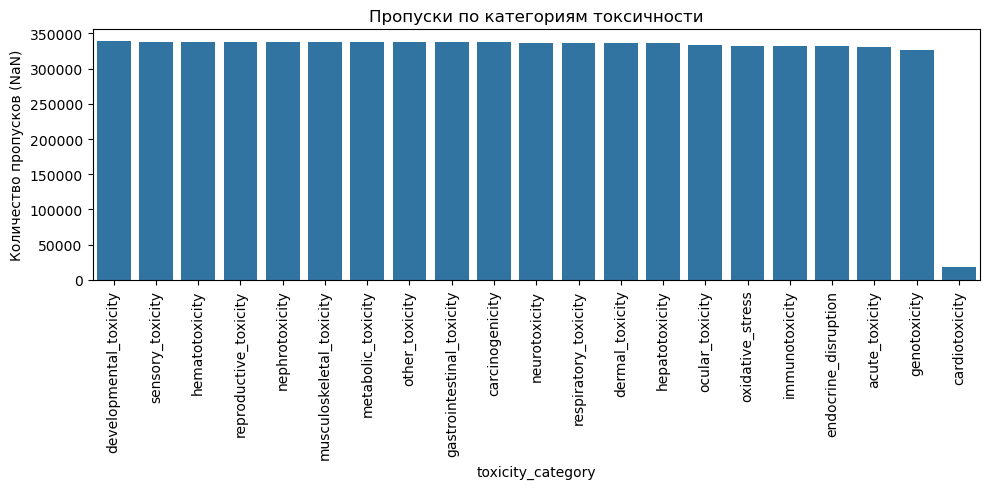

Топ-10 категорий по числу положительных случаев (1):
toxicity_category
cardiotoxicity          22146.0
genotoxicity             4850.0
ocular_toxicity          4611.0
immunotoxicity           2385.0
acute_toxicity           2323.0
dermal_toxicity          2070.0
hepatotoxicity           1883.0
respiratory_toxicity     1829.0
endocrine_disruption     1821.0
neurotoxicity            1665.0
dtype: float64


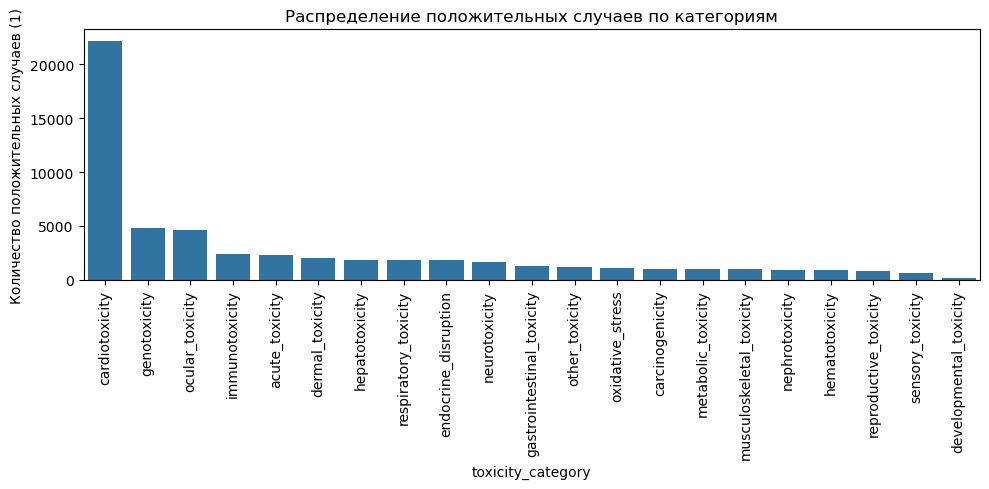

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

categories = multi_target_df.columns.drop('smiles')

# Количество пропусков и плотность
nan_counts = multi_target_df[categories].isna().sum().sort_values(ascending=False)
total_values = multi_target_df[categories].size
non_missing = multi_target_df[categories].count().sum()
density = non_missing / total_values
print(f"Плотность заполненных значений: {density:.3f}")
print("Топ-10 категорий с наибольшим количеством пропусков:")
print(nan_counts.head(10))

# Количество пропусков по категориям, Визуал
plt.figure(figsize=(10,5))
sns.barplot(x=nan_counts.index, y=nan_counts.values)
plt.xticks(rotation=90)
plt.ylabel("Количество пропусков (NaN)")
plt.title("Пропуски по категориям токсичности")
plt.tight_layout()
plt.show()

# Распределение положительных случаев по категориям
positive_counts = multi_target_df[categories].sum(skipna=True).sort_values(ascending=False)
print("Топ-10 категорий по числу положительных случаев (1):")
print(positive_counts.head(10))

# Количество положительных случаев, Визуал
plt.figure(figsize=(10,5))
sns.barplot(x=positive_counts.index, y=positive_counts.values)
plt.xticks(rotation=90)
plt.ylabel("Количество положительных случаев (1)")
plt.title("Распределение положительных случаев по категориям")
plt.tight_layout()
plt.show()
